### Importing tensorflow and required modules

In [1]:
import tensorflow as tf
import gradio as gr
import numpy as np
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt

In [14]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=5

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

### Reading image

Image Batch size:  (32, 256, 256, 3)
Lables in one batch size: 
 [2 2 2 2 2 0 0 2 0 2 1 0 0 0 0 2 1 2 2 1 2 1 1 2 1 2 1 0 1 0 2 0]


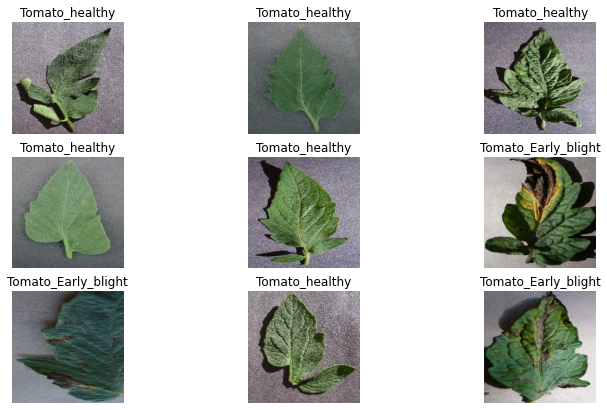

In [5]:
plt.figure(figsize=(12,7))
for image_batch, label_batch in dataset.take(1):
    print('Image Batch size: ',image_batch.shape)
    print('Lables in one batch size: \n',label_batch.numpy())
    
    for i in range(9):
        sub = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Data Preprocessing and Augmentation

In [6]:
def get_partitions_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    assert(train_split+val_split+test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=0)
    
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, val_ds, test_ds

In [7]:
# Using cache and prefetch


train_ds, val_ds, test_ds = get_partitions_dataset(dataset)


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Resize and rescale

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [9]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)])

### Model creation and training

In [10]:
#Model Architecture

input1 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
])

model.build(input_shape=input1)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 256, 256, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 128, 128, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 128, 128, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 64, 64, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 64, 64, 64)         

In [12]:
model.compile(optimizer='adam', 
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'] 
             )

In [15]:
#Training

history = model.fit(train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1)

Epoch 1/5
75/75 [==============================] - 253s 3s/step - loss: 0.8199 - accuracy: 0.6108 - val_loss: 0.9752 - val_accuracy: 0.6181
Epoch 2/5
75/75 [==============================] - 254s 3s/step - loss: 0.4455 - accuracy: 0.8169 - val_loss: 0.9397 - val_accuracy: 0.7118
Epoch 3/5
75/75 [==============================] - 249s 3s/step - loss: 0.4023 - accuracy: 0.8332 - val_loss: 0.7708 - val_accuracy: 0.7396
Epoch 4/5
75/75 [==============================] - 250s 3s/step - loss: 0.3759 - accuracy: 0.8462 - val_loss: 0.4081 - val_accuracy: 0.8438
Epoch 5/5
75/75 [==============================] - 248s 3s/step - loss: 0.3051 - accuracy: 0.8704 - val_loss: 0.4480 - val_accuracy: 0.8299


In [17]:
model.save('Tomato.h5')

### Model Evaluation

In [18]:
scores=model.evaluate(test_ds)

10/10 [==============================] - 12s 854ms/step - loss: 0.4861 - accuracy: 0.8045


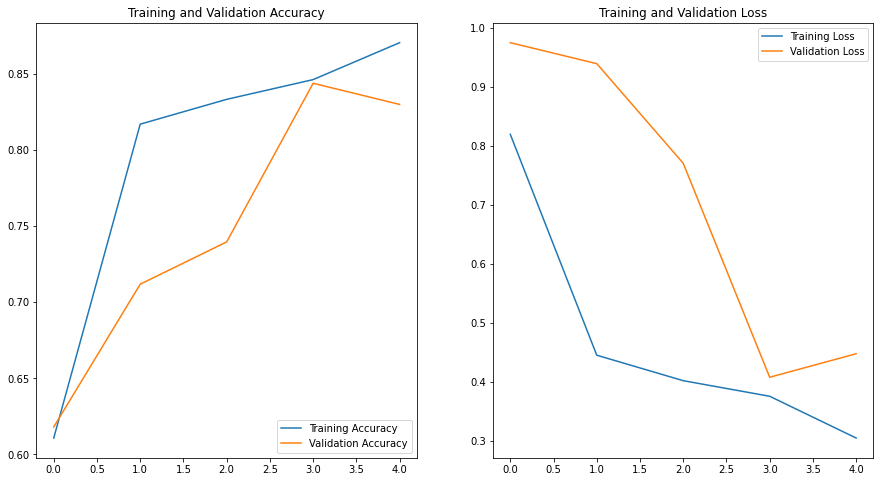

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction

First image to predict
Actual flower:  Early blight
Predicted Flower:  Early blight


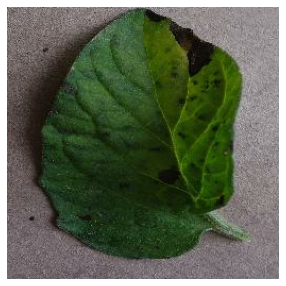

In [36]:
import numpy as np
plt.figure(figsize=(8,5))
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual flower: ', class_names[label_batch[0].numpy()])
    
    batch_prediction = model.predict(image_batch)
    print('Predicted Flower: ',class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')